In [1]:
%matplotlib inline
from pytorch_metric_learning import losses, miners, samplers, trainers, testers
import pytorch_metric_learning.utils.logging_presets as logging_presets
import numpy as np
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
from torch.utils.data import ConcatDataset, Subset
from PIL import Image
import logging
import matplotlib.pyplot as plt
logging.getLogger().setLevel(logging.INFO)

import pytorch_metric_learning
logging.info("VERSION %s"%pytorch_metric_learning.__version__)

INFO:root:VERSION 0.9.84.dev2


In [2]:
class MLP(nn.Module):
    # layer_sizes[0] is the dimension of the input
    # layer_sizes[-1] is the dimension of the output
    def __init__(self, layer_sizes, final_relu=False):
        super().__init__()
        layer_list = []
        layer_sizes = [int(x) for x in layer_sizes]
        num_layers = len(layer_sizes) - 1
        final_relu_layer = num_layers if final_relu else num_layers - 1
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            curr_size = layer_sizes[i + 1]
            if i < final_relu_layer:
                layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.Linear(input_size, curr_size))
        self.net = nn.Sequential(*layer_list)
        self.last_linear = self.net[-1]

    def forward(self, x):
        return self.net(x)

class Identity(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [3]:
##############################
########## Training ##########
##############################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set trunk model and replace the softmax layer with an identity function
trunk = models.resnet18(pretrained=True)
trunk_output_size = trunk.fc.in_features
trunk.fc = Identity()
trunk = torch.nn.DataParallel(trunk.to(device))

# Set embedder model. This takes in the output of the trunk and outputs 64 dimensional embeddings
embedder = torch.nn.DataParallel(MLP([trunk_output_size, 64]).to(device))

# Set optimizers
trunk_optimizer = torch.optim.Adam(trunk.parameters(), lr=0.0001, weight_decay=0.00005)
embedder_optimizer = torch.optim.Adam(embedder.parameters(), lr=0.001, weight_decay=0.00005)

# Set the image transforms
train_transform = transforms.Compose([transforms.Resize(64),
                                    transforms.RandomResizedCrop(scale=(0.16, 1), ratio=(0.75, 1.33), size=64),
                                    transforms.RandomHorizontalFlip(0.5),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

val_transform = transforms.Compose([transforms.Resize(64),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])





In [4]:
# Download the original datasets
original_train = datasets.CIFAR100(root="CIFAR100_Dataset", train=True, transform=None, download=True)
original_val = datasets.CIFAR100(root="CIFAR100_Dataset", train=False, transform=None, download=True)

# This will be used to create train and val sets that are class-disjoint
class ClassDisjointCIFAR100(torch.utils.data.Dataset):
    def __init__(self, original_train, original_val, train, transform):
        rule = (lambda x: x < 50) if train else (lambda x: x >=50)
        train_filtered_idx = [i for i,x in enumerate(original_train.targets) if rule(x)]
        val_filtered_idx = [i for i,x in enumerate(original_val.targets) if rule(x)]
        self.data = np.concatenate([original_train.data[train_filtered_idx], original_val.data[val_filtered_idx]], axis=0)
        self.targets = np.concatenate([np.array(original_train.targets)[train_filtered_idx], np.array(original_val.targets)[val_filtered_idx]], axis=0)
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):            
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target

# Class disjoint training and validation set
train_dataset = ClassDisjointCIFAR100(original_train, original_val, True, train_transform)
val_dataset = ClassDisjointCIFAR100(original_train, original_val, False, val_transform)
assert set(train_dataset.targets).isdisjoint(set(val_dataset.targets))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Set the loss function
loss = losses.TripletMarginLoss(margin=0.1)

# Set the mining function
miner = miners.MultiSimilarityMiner(epsilon=0.1)

# Set the dataloader sampler
sampler = samplers.MPerClassSampler(train_dataset.targets, m=4, length_before_new_iter=len(train_dataset))

# Set other training parameters
batch_size = 32
num_epochs = 10

# Package the above stuff into dictionaries.
models = {"trunk": trunk, "embedder": embedder}
optimizers = {"trunk_optimizer": trunk_optimizer, "embedder_optimizer": embedder_optimizer}
loss_funcs = {"metric_loss": loss}
mining_funcs = {"tuple_miner": miner}

record_keeper, _, _ = logging_presets.get_record_keeper("example_logs", "example_tensorboard")
hooks = logging_presets.get_hook_container(record_keeper)
dataset_dict = {"train": train_dataset, "val": val_dataset}
model_folder = "example_saved_models"

INFO:root:Initializing dataloader
INFO:root:Initializing dataloader iterator
INFO:root:Done creating dataloader iterator
INFO:root:TRAINING EPOCH 1
total_loss=0.08260: 100%|██████████| 937/937 [05:53<00:00,  2.65it/s]
INFO:root:Evaluating epoch 1
INFO:root:Getting embeddings for the train split
100%|██████████| 938/938 [00:31<00:00, 30.16it/s]
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:31<00:00, 30.05it/s]
INFO:root:Running UMAP on the train set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


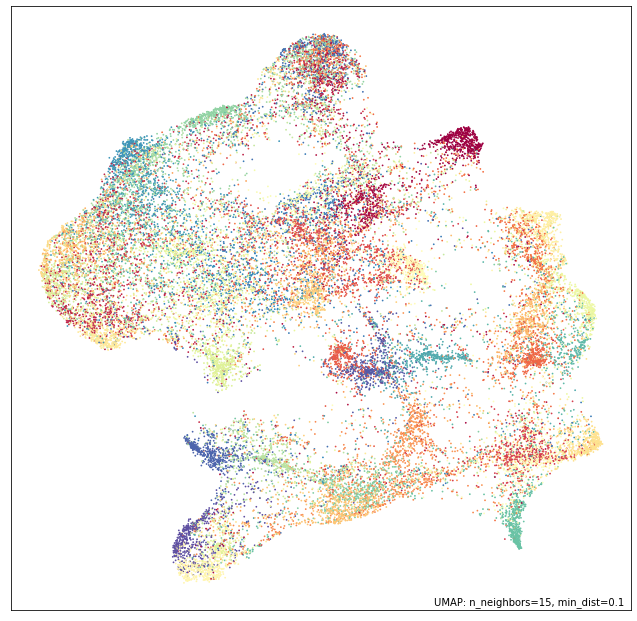

INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


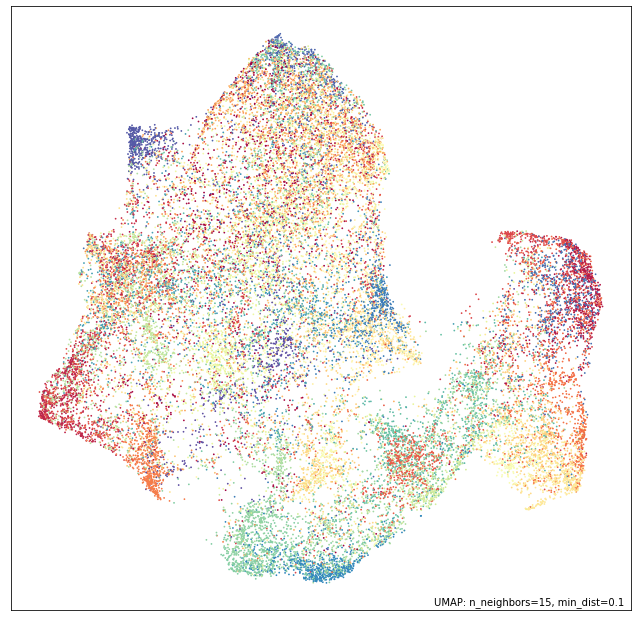

INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 2
total_loss=0.08207: 100%|██████████| 937/937 [05:48<00:00,  2.69it/s]
INFO:root:Evaluating epoch 2
INFO:root:Getting embeddings for the train split
100%|██████████| 938/938 [00:30<00:00, 30.49it/s]
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:30<00:00, 30.47it/s]
INFO:root:Running UMAP on the train set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


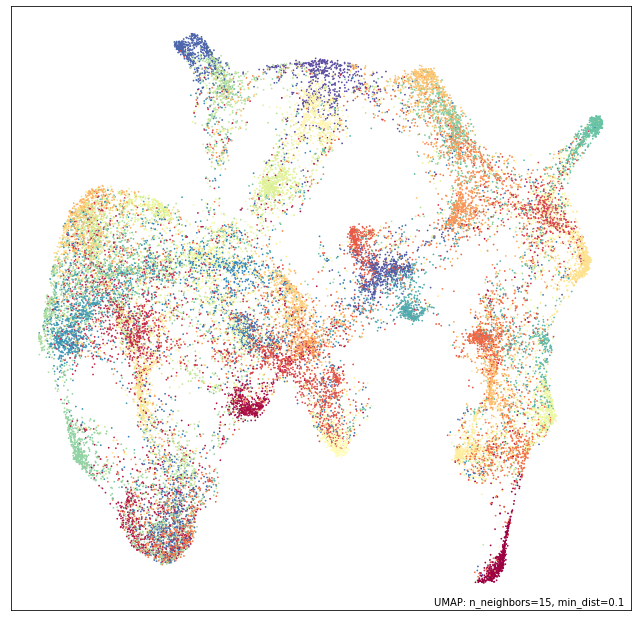

INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


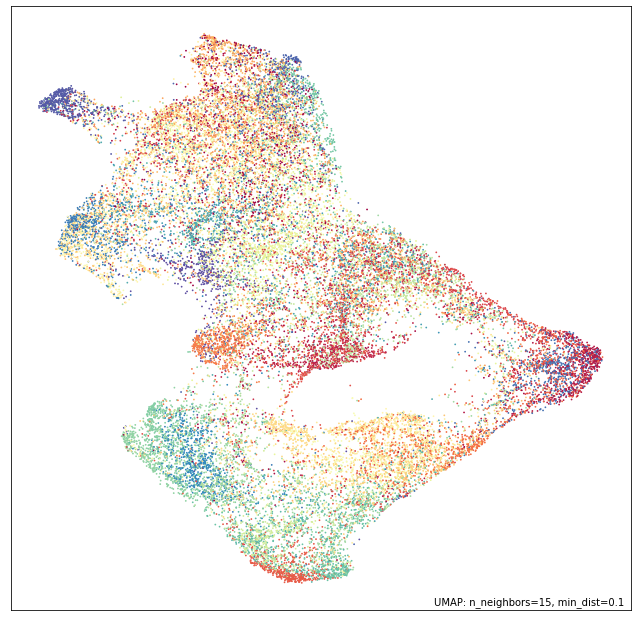

INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:New best accuracy!
INFO:root:TRAINING EPOCH 3
total_loss=0.10170: 100%|██████████| 937/937 [05:50<00:00,  2.67it/s]
INFO:root:Evaluating epoch 3
INFO:root:Getting embeddings for the train split
100%|██████████| 938/938 [00:31<00:00, 29.82it/s]
INFO:root:Getting embeddings for the val split
100%|██████████| 938/938 [00:31<00:00, 29.89it/s]
INFO:root:Running UMAP on the train set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the train split and label set UMAP_level0


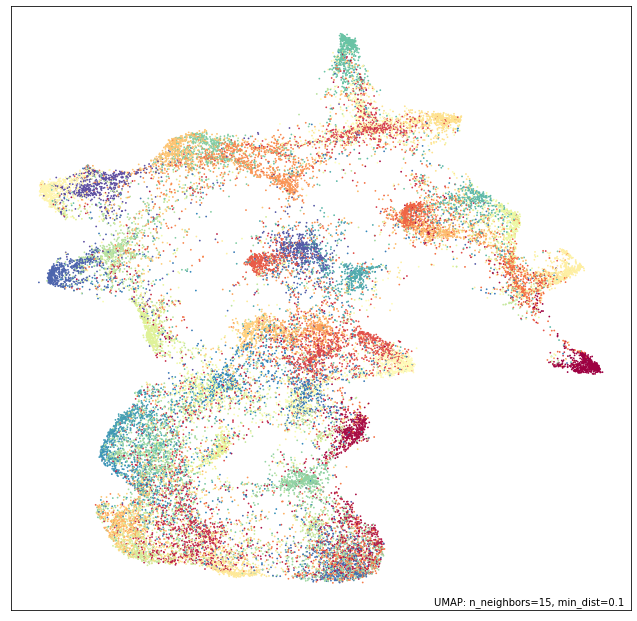

INFO:root:Running UMAP on the val set
INFO:root:Finished UMAP
INFO:root:UMAP plot for the val split and label set UMAP_level0


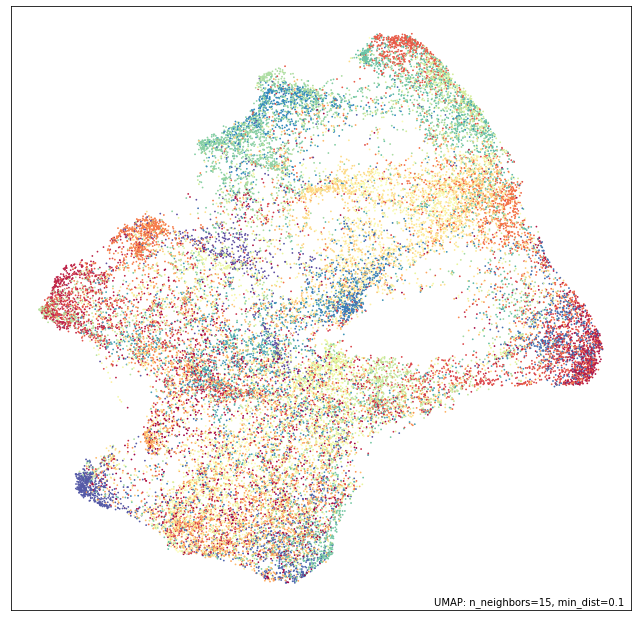

INFO:root:Computing accuracy for the train split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:Computing accuracy for the val split
INFO:root:running k-nn with k=600
INFO:root:embedding dimensionality is 64
INFO:root:running k-means clustering with k=50
INFO:root:embedding dimensionality is 64
INFO:root:Validation accuracy has plateaued. Exiting.


In [6]:
import umap
import umap.plot
def visualizer_hook(umapper, umap_embeddings, labels, split_name, keyname):
    logging.info("UMAP plot for the {} split and label set {}".format(split_name, keyname))
    umap.plot.points(umapper, labels=labels, show_legend=False)
    plt.show()


# Create the tester
tester = testers.GlobalEmbeddingSpaceTester(end_of_testing_hook=hooks.end_of_testing_hook, 
                                            visualizer=umap.UMAP(), 
                                            visualizer_hook=visualizer_hook)

end_of_epoch_hook = hooks.end_of_epoch_hook(tester, 
                                            dataset_dict, 
                                            model_folder, 
                                            test_interval=1,
                                            patience=0)
trainer = trainers.MetricLossOnly(models,
                                optimizers,
                                batch_size,
                                loss_funcs,
                                mining_funcs,
                                train_dataset,
                                sampler=sampler,
                                dataloader_num_workers=2,
                                end_of_iteration_hook=hooks.end_of_iteration_hook,
                                end_of_epoch_hook=end_of_epoch_hook)

trainer.train(num_epochs=num_epochs)